In [115]:
pip install pyscipopt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp

In [32]:
# Set seed for reproducibility
np.random.seed(0)

# Parameters
n = 100
n_covariates = 5
p = n_covariates + 1  # one extra for intercept

# Simulate design: first column of ones, then your covariate(s)
X = np.hstack([
    np.ones((n, 1)), 
    np.random.randint(-5, 5, size=(n, n_covariates))
])

# True coefficients for β and α
beta_true  = np.random.randint(low=-2, high=2, size=p).reshape(-1,1)
alpha_true = 1

# Simulate treatment variable d and response y with noise
d = np.random.randint(low=-5, high=5, size=n).reshape(-1,1)
noise = np.random.randint(low=-2, high=2, size=n).reshape(-1,1)
y = alpha_true * d + X @ beta_true + noise

# Create DataFrame
columns = ['y', 'd'] + [f'x{i+1}' for i in range(p)]
df = pd.DataFrame(np.hstack([y, d, X]), columns=columns)

print(df)

       y    d   x1   x2   x3   x4   x5   x6
0    6.0 -3.0  1.0  0.0 -5.0 -2.0 -2.0  2.0
1    8.0  2.0  1.0  4.0 -2.0  0.0 -3.0 -1.0
2  -12.0 -4.0  1.0  2.0  1.0  3.0  3.0 -4.0
3   -4.0  4.0  1.0  1.0  2.0  2.0  3.0 -4.0
4  -13.0 -3.0  1.0  0.0  4.0  3.0  4.0 -1.0
..   ...  ...  ...  ...  ...  ...  ...  ...
95  -3.0  2.0  1.0 -3.0 -1.0  4.0  2.0 -1.0
96  14.0  4.0  1.0  4.0 -1.0 -4.0 -3.0  2.0
97  -5.0 -3.0  1.0 -3.0 -2.0  4.0  2.0  1.0
98  -3.0 -1.0  1.0  1.0 -3.0 -2.0  1.0 -5.0
99   9.0  4.0  1.0  3.0 -5.0  2.0  1.0  0.0

[100 rows x 8 columns]


## l1 penalized penalized QR

In [3]:
import numpy as np
from typing import Tuple, Optional
import cvxpy as cp
import matplotlib.pyplot as plt

In [4]:
def compute_diagonal_psi(
    d: np.ndarray,
    X: np.ndarray
) -> np.ndarray:
    """
    Compute the diagonal scaling matrix psi.

    Parameters
    ----------
    d : np.ndarray
        Treatment variable vector of shape (n,).
    X : np.ndarray
        Covariate matrix of shape (n, p).

    Returns
    -------
    np.ndarray
        (p+1) x (p+1) diagonal matrix whose entries are the
        root-mean-square of d and each column of X.
    """
    _, p = X.shape
    psi = np.empty(p + 1, dtype=float)
    psi[0] = np.sqrt(np.mean(d ** 2))
    psi[1:] = np.sqrt(np.mean(X ** 2, axis=0))
    psi_diag = np.diag(psi)
    return psi_diag

psi_diag_test = compute_diagonal_psi(d, X)
print(psi_diag_test)

[[2.82842712 0.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         2.88097206 0.         0.         0.
  0.        ]
 [0.         0.         0.         2.68328157 0.         0.
  0.        ]
 [0.         0.         0.         0.         2.95127091 0.
  0.        ]
 [0.         0.         0.         0.         0.         3.00665928
  0.        ]
 [0.         0.         0.         0.         0.         0.
  2.98831056]]


In [5]:
def compute_penalty_parameter(
    d: np.ndarray,
    X: np.ndarray,
    psi_diag: np.ndarray,
    tau: float = 0.5,
    gamma: Optional[float] = None,
    n_sim: int = 500,
    random_state: int = 0
) -> float:
    """
    Estimate the penalty tuning parameter for quantile regression.

    Parameters
    ----------
    d : np.ndarray
        Treatment variable vector of shape (n,).
    X : np.ndarray
        Covariate matrix of shape (n, p).
    psi_diag : np.ndarray
        (p+1) x (p+1) diagonal scaling matrix.
    tau : float, optional
        Quantile level in (0,1), by default 0.5.
    gamma : float, optional
        Tail probability for quantile of sup-norm; defaults to 0.05/n.
    n_sim : int, optional
        Number of Monte Carlo simulations, by default 500.
    random_state : int, optional
        Seed for reproducibility, by default 0.

    Returns
    -------
    float
        Penalty parameter lambda_tau.
    """
    n, _ = X.shape
    gamma = gamma if gamma is not None else 0.05 / n

    psi_inv = np.linalg.inv(psi_diag)

    Z = np.column_stack((d, X)).transpose()

    rng = np.random.default_rng(random_state)

    sup_norms = np.empty(n_sim)

    for i in range(n_sim):
        U = rng.random(n)
        weights = tau - (U <= tau).astype(float)
        avg_scores = (weights * Z).mean(axis=1).reshape(-1,1)
        scaled = psi_inv@avg_scores
        sup_norms[i] = np.linalg.norm(scaled, np.inf)


    q = np.quantile(sup_norms, 1 - gamma)
    lambda_tau = 1.1 * q * n
    return lambda_tau

lambda_test = compute_penalty_parameter(d, X, psi_diag_test)
print(lambda_test)

22.627135369664124


In [6]:
def quantile_loss(
    d: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    alpha: cp.Variable,
    beta: cp.Variable,
    tau: float = 0.5
) -> cp.Expression:
    """
    Compute the quantile (pinball) loss for residuals.

    Parameters
    ----------
    d : np.ndarray
        Treatment variable vector of shape (n,).
    X : np.ndarray
        Covariate matrix of shape (n, p).
    y : np.ndarray
        Outcome vector of shape (n,).
    alpha : cp.Variable
        Scalar intercept variable.
    beta : cp.Variable
        Coefficient variables of shape (p,).
    tau : float, optional
        Quantile level in (0,1), by default 0.5.

    Returns
    -------
    cp.Expression
        Vector of loss values: tau*max(r,0)+(1-tau)*max(-r,0).
    """
    r = y - d * alpha - X @ beta
    return tau * cp.pos(r) + (1 - tau) * cp.pos(-r)

alpha = cp.Variable(shape=(1,1), name="alpha")
beta  = cp.Variable(shape=(p,1), name="beta")
quantile_loss_test = quantile_loss(d, X, y, alpha, beta)
print(quantile_loss_test)
# print(quantile_loss_test)

Promote(0.5, (100, 1)) @ maximum([[6.00]
 [8.00]
 ...
 [-3.00]
 [9.00]] + -[[-3.00]
 [2.00]
 ...
 [-1.00]
 [4.00]] @ alpha + -[[1.00 0.00 ... -2.00 2.00]
 [1.00 4.00 ... -3.00 -1.00]
 ...
 [1.00 1.00 ... 1.00 -5.00]
 [1.00 3.00 ... 1.00 0.00]] @ beta, 0.0) + Promote(0.5, (100, 1)) @ maximum(-[[6.00]
 [8.00]
 ...
 [-3.00]
 [9.00]] + -[[-3.00]
 [2.00]
 ...
 [-1.00]
 [4.00]] @ alpha + -[[1.00 0.00 ... -2.00 2.00]
 [1.00 4.00 ... -3.00 -1.00]
 ...
 [1.00 1.00 ... 1.00 -5.00]
 [1.00 3.00 ... 1.00 0.00]] @ beta, 0.0)


/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


In [7]:
def l1_penalized_quantile_regression(
    X: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    tau: float = 0.5
) -> Tuple[float, np.ndarray]:
    """
    Solve L1-penalized quantile regression via CVXPY.

    Parameters
    ----------
    X : np.ndarray
        Covariate matrix of shape (n, p).
    d : np.ndarray
        Treatment variable vector of shape (n,).
    y : np.ndarray
        Outcome vector of shape (n,).
    tau : float, optional
        Quantile level in (0,1), by default 0.5.

    Returns
    -------
    Tuple[float, np.ndarray]
        Estimated intercept alpha and coefficient vector beta.
    """
    n, p = X.shape

    theta = cp.Variable((p+1, 1))

    psi_diag = compute_diagonal_psi(d, X)
    lambda_tau = compute_penalty_parameter(d, X, psi_diag, tau)/n

    penalty = lambda_tau * cp.norm(psi_diag@theta, 1)

    u = y-d*theta[0]-X@theta[1:]
    check = cp.mean(cp.maximum(tau*u, (tau-1)*u))

    problem = cp.Problem(
        cp.Minimize(check + penalty)
    )
    problem.solve(verbose=False)

    theta_opt = theta.value

    return theta_opt

theta_l1_test = l1_penalized_quantile_regression(X, d, y)
print(theta_l1_test)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


[[ 5.22989624e-10]
 [-2.66386897e-07]
 [ 5.49006514e-07]
 [-7.46202429e-07]
 [ 9.91521875e-10]
 [-5.30352824e-07]
 [ 2.60933832e-07]]


/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-

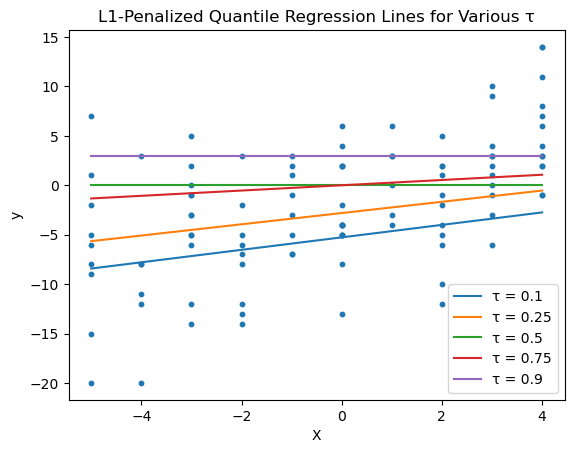

In [8]:
import numpy as np

# Define the quantile levels to plot
taus = [0.1, 0.25, 0.5, 0.75, 0.9]

# Generate a smooth range for X to draw lines
X_vals = np.hstack([
    np.ones((n, 1)),
    np.linspace(X[:,1].min(), X[:,1].max(), n).reshape(-1, 1)
])

# Scatter the original data
plt.scatter(X[:,1], y, s=10)

# Fit and plot for each tau
for tau in taus:
    theta = l1_penalized_quantile_regression(X, d, y, tau)
    y_pred = X_vals@theta[1:3]
    plt.plot(X_vals[:,1], y_pred, label=f"τ = {tau}")

# Labels and legend
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("L1-Penalized Quantile Regression Lines for Various τ")
plt.show()


## Conditional Density

In [9]:
import numpy as np

In [10]:
def bandwidth_selection(
    X: np.ndarray,
    tau: float = 0.5
) -> float:
    """
    Compute the bandwidth h_n for quantile density estimation.

    Parameters
    ----------
    X : np.ndarray
        Input data array of shape (n_samples, n_features).
    tau : float
        Quantile level in (0,1).

    Returns
    -------
    float
        Bandwidth h_n = min(n_samples**(-1/6), tau*(1-tau)/2).
    """
    n, _ = X.shape
    bandwidth = min(n**(-1/6), tau * (1 - tau) / 2)
    return bandwidth

taus = np.linspace(0.000000001, 0.9999999999, 10)

print(f"{'τ':>6}   {'h':>10}   {'τ−h':>10}   {'τ+h':>10}")
print("-"*40)
for tau in taus:
    h = bandwidth_selection(X, tau)
    print(f"{tau:6.3f}   {h:10.3e}   {tau-h:10.3f}   {tau+h:10.3f}")


bandwith = bandwidth_selection(X, 0.5)

     τ            h          τ−h          τ+h
----------------------------------------
 0.000    5.000e-10        0.000        0.000
 0.111    4.938e-02        0.062        0.160
 0.222    8.642e-02        0.136        0.309
 0.333    1.111e-01        0.222        0.444
 0.444    1.235e-01        0.321        0.568
 0.556    1.235e-01        0.432        0.679
 0.667    1.111e-01        0.556        0.778
 0.778    8.642e-02        0.691        0.864
 0.889    4.938e-02        0.840        0.938
 1.000    5.000e-11        1.000        1.000


In [11]:
def conditional_quantile_function(
    X: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    u: float,
) -> np.ndarray:
    """
    Compute the estimated conditional quantile Q(u | z_i, d_i) via L1-penalized quantile regression.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Covariate matrix (including control variables and treatment indicators).
    d : np.ndarray of shape (n_samples,)
        Treatment or primary variable of interest.
    y : np.ndarray of shape (n_samples,)
        Outcome variable.
    u : float
        Quantile level in (0,1) at which to estimate the conditional quantile.

    Returns
    -------
    np.ndarray of shape (n_samples,)
        Fitted values hat Q(u | z_i, d_i) for each observation.
    """
    theta = l1_penalized_quantile_regression(X, d, y, tau=u)
    Q_hat = theta[0]*d+X@theta[1:]
    return Q_hat

Q_hat_test = conditional_quantile_function(X, d, y, 0.5-bandwith)
print(Q_hat_test)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


[[ 7.87877017e-01]
 [ 1.70345496e-06]
 [-1.51515124e+00]
 [-1.63636420e+00]
 [-4.84850354e-01]
 [-2.42424488e+00]
 [-1.27273099e+00]
 [-2.00000264e+00]
 [ 1.27272827e+00]
 [-2.42424492e+00]
 [-2.42430074e-01]
 [ 2.00000015e+00]
 [ 2.00000024e+00]
 [-8.48482959e-01]
 [-1.09091467e+00]
 [-1.03030534e+00]
 [-1.03030525e+00]
 [-1.51515106e+00]
 [-6.06079134e-02]
 [-1.93939908e+00]
 [ 1.81812345e-01]
 [ 7.87876631e-01]
 [-1.27273130e+00]
 [-1.69697328e+00]
 [ 1.69697088e+00]
 [-4.10907861e-06]
 [ 6.06054449e-01]
 [-9.69696034e-01]
 [ 6.06054360e-01]
 [-2.54545812e+00]
 [ 1.09090615e+00]
 [-2.78788406e+00]
 [-1.27272532e+00]
 [ 7.27273380e-01]
 [ 1.63636120e+00]
 [ 1.27272243e+00]
 [-1.39394416e+00]
 [-4.15944468e-06]
 [-4.84850248e-01]
 [-7.87879429e-01]
 [ 1.50756518e-06]
 [ 1.63636139e+00]
 [-8.48483160e-01]
 [-3.03033867e-01]
 [-2.24242856e+00]
 [-1.33333474e+00]
 [-1.75757703e+00]
 [ 7.27267551e-01]
 [-1.03030534e+00]
 [-1.51515098e+00]
 [-4.24246342e-01]
 [ 7.87876760e-01]
 [ 1.0303025

In [12]:
def conditional_density_function(
    X: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    tau: float,
) -> np.ndarray:
    """
    Estimate the conditional density at the tau-quantile f(Y|X,D) by finite differences.

    We use a symmetric difference quotient on the estimated conditional quantile function:
        f_hat = 2*h / (Q̂(τ + h) - Q̂(τ - h)).

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Covariate matrix (including controls and treatment).
    d : np.ndarray of shape (n_samples,)
        Treatment or variable of interest.
    y : np.ndarray of shape (n_samples,)
        Outcome variable.
    tau : float
        Target quantile level in (0,1).

    Returns
    -------
    np.ndarray of shape (n_samples,)
        Estimated conditional density f_hat at the tau-quantile for each observation.
    """
    # Select bandwidth
    h = bandwidth_selection(X, tau)
    # Evaluate quantile function at tau +/- h
    Q_plus  = conditional_quantile_function(X, d, y, tau + h)
    Q_minus = conditional_quantile_function(X, d, y, tau - h)

    f_hat = 2 * h / (Q_plus - Q_minus)

    # Preliminary fix: change negatives to 0
    f_hat = np.where(f_hat<0,0,f_hat)
    return f_hat

f_hat = conditional_density_function(X, d, y, 0.5)
print(f_hat)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-

[[0.00000000e+00]
 [6.95553389e+04]
 [1.64999748e-01]
 [1.52777607e-01]
 [5.15623072e-01]
 [1.03125007e-01]
 [1.96428602e-01]
 [1.24999998e-01]
 [0.00000000e+00]
 [1.03125005e-01]
 [1.03125317e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.94641688e-01]
 [2.29166881e-01]
 [2.42646826e-01]
 [2.42646844e-01]
 [1.64999761e-01]
 [4.12487334e+00]
 [1.28906345e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.96428564e-01]
 [1.47321458e-01]
 [0.00000000e+00]
 [1.20402660e+06]
 [0.00000000e+00]
 [2.57811703e-01]
 [0.00000000e+00]
 [9.82143013e-02]
 [0.00000000e+00]
 [8.96739576e-02]
 [1.96428062e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.79347895e-01]
 [1.05155515e+06]
 [5.15623164e-01]
 [3.17306899e-01]
 [6.65238303e+04]
 [0.00000000e+00]
 [2.94641622e-01]
 [8.24997576e-01]
 [1.11486534e-01]
 [1.87499802e-01]
 [1.42241280e-01]
 [0.00000000e+00]
 [2.42646832e-01]
 [1.64999768e-01]
 [5.89285698e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.89285493e-01]
 [0.00000000e+00]
 [9.375003

## Weighted Lasso Estimator

In [13]:
from scipy.stats import norm
import numpy as np
import cvxpy as cp
from typing import Tuple, Union

In [14]:
def lambda_lasso(
        X: np.ndarray,
        gamma: Optional[float] = None,
) -> float:
    """
    Compute the LASSO‐penalty tuning parameter
        λ = 1.1 * sqrt(n) * Phi^{-1}(1 - gamma/(2p))
    
    Parameters
    ----------
    n : int
        Number of observations.
    gamma : float
        Tail‐probability control, e.g. 0.1 for 90%.
    p : int
        Number of covariates.
    
    Returns
    -------
    float
        The value of λ.
    """
    n, p = X.shape
    gamma = gamma if gamma is not None else 0.05 / n

    q = 1 - gamma / (2 * p)
    inv = (norm.cdf(q))**(-1)
    
    lambda_lasso = 1.1*np.sqrt(n)*2*inv
    return lambda_lasso

lambda_lasso_test = lambda_lasso(X)
print(lambda_lasso_test)

26.14892853941481


In [15]:
def penalty_loading_init(
    f_hat: np.ndarray,
    X:     np.ndarray,
    d:     np.ndarray
) -> np.ndarray:
    """
    Initial penalty loadings:
        ψ_j^(0) = max_i |f̂_i X_{i,j}| * sqrt(E_n[f̂_i^2 d_i^2]).
    """
    sup_norm = np.max(np.abs(f_hat*X), axis=0)
    l2_norm = np.sqrt(np.mean(f_hat**2*d**2))

    psi_flat = sup_norm*l2_norm
    psi_init = np.diag(psi_flat)
    return psi_init

psi_init_test = penalty_loading_init(f_hat, X, d)
print(psi_init_test)

[[5.42990636e+11 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.62897191e+12 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.08598127e+12 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.71495318e+12
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.71495318e+12 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.42990636e+11]]


In [16]:
def weighted_lasso(
    X: np.ndarray,
    d: np.ndarray,
    f_hat: np.ndarray,
    psi_diag: np.ndarray,
    solver: str = 'CLARABEL'
) -> np.ndarray:
    """
    Solve a weighted LASSO regression problem via CVXPY.

    Parameters
    ----------
    X : np.ndarray
        Design matrix of shape (n, p).
    d : np.ndarray
        Response vector of length n.
    f_hat : np.ndarray
        Vector of sample weights of length n (for weighted loss).
    psi_diag : np.ndarray
        Diagonal weighting matrix of shape (p, p) for the ℓ₁ penalty.
    solver : str, default='CLARABEL'
        Name of the CVXPY solver to use.

    Returns
    -------
    theta_hat : np.ndarray
        Estimated coefficient vector of length p.
    """
    
    n, p = X.shape
    theta = cp.Variable((p,1), name="theta")
    lambda_weighted = lambda_lasso(X)/n
    penalty = lambda_weighted * cp.norm(psi_diag@theta, 1)

    resid = d - X @ theta
    weighted_loss = cp.mean(cp.multiply(f_hat,resid**2))

    objective = weighted_loss + penalty
    # Solve
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve(
        solver,
        verbose=False
    )

    # Extract
    theta_hat = theta.value
    return theta_hat

theta_post_test = weighted_lasso(X, d, f_hat, psi_init_test)
print(theta_post_test)

[[ 9.29085682e-27]
 [-3.17158438e-27]
 [-4.46618239e-27]
 [-4.17098799e-28]
 [-7.31512378e-28]
 [ 9.42448635e-27]]


In [17]:
def penalty_loading_updated(
    f_hat: np.ndarray,
    X:     np.ndarray,
    d:     np.ndarray,
    theta: np.ndarray,
) -> np.ndarray:

    residuals = f_hat*(d-X@theta)
    psi_flat = np.sqrt(np.mean(f_hat**2*X**2*residuals**2, axis=0))
    psi_updated = np.diag(psi_flat)
    return psi_updated

psi_updated_test = penalty_loading_updated(f_hat, X, d, theta_post_test)
print(psi_updated_test)

[[4.97819754e+11 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.49346191e+12 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.95639508e+11 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.38064015e+12
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.22784072e+12 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.97819754e+11]]


In [18]:
def lasso(
    X: np.ndarray,
    d: np.ndarray,
    f_hat: np.ndarray,
    post_lasso: bool = False
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """
    Perform a two‐step (post-)LASSO regression using adaptive penalty loadings.

    Parameters
    ----------
    X : np.ndarray
        Design matrix of shape (n, p).
    d : np.ndarray
        Outcome vector of length n.
    f_hat : np.ndarray
        Observation weights of length n.
    post_lasso : bool, default=False
        If True, return both the initial (post-LASSO) and final LASSO estimates.

    Returns
    -------
    theta_lasso : np.ndarray
        Final LASSO coefficient vector of length p.
    theta_post : np.ndarray, optional
        Initial (“post-LASSO”) coefficient vector of length p; only returned if `post_lasso=True`.
    """
    # Initial penalty loadings and post-LASSO fit
    psi_init = penalty_loading_init(f_hat, X, d)
    theta_post = weighted_lasso(X, d, f_hat, psi_init)

    # Update penalty loadings and final LASSO fit
    psi_updated = penalty_loading_updated(f_hat, X, d, theta_post)
    theta_lasso = weighted_lasso(X, d, f_hat, psi_updated)

    if post_lasso:
        return theta_lasso, theta_post

    return theta_lasso

theta_lasso_test, theta_post_test = lasso(X,d,f_hat,post_lasso=True)
print(theta_lasso_test, "\n\n", theta_post_test)


[[ 1.08302881e-26]
 [-3.70812348e-27]
 [-5.29948308e-27]
 [-5.35849095e-28]
 [-1.07407710e-27]
 [ 1.09858998e-26]] 

 [[ 9.29085682e-27]
 [-3.17158438e-27]
 [-4.46618239e-27]
 [-4.17098799e-28]
 [-7.31512378e-28]
 [ 9.42448635e-27]]


## Weighted Double Selection

In [19]:
def weighted_double_selection(
    X: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    tau: float = 0.5
) -> Tuple[float, np.ndarray]:

    theta_l1 = l1_penalized_quantile_regression(X, d, y, tau)

    f_hat = conditional_density_function(X, d, y, tau)
    
    theta_lasso = lasso(X,d,f_hat,post_lasso=False)

    psi_diag = compute_diagonal_psi(d, X)
    lambda_tau = compute_penalty_parameter(d, X, psi_diag, tau)     

    l1_treshold = lambda_tau / np.sqrt(np.mean(X ** 2, axis=0))

    mask = ((theta_lasso != 0) & (abs(theta_l1[1:,]) > l1_treshold.reshape(-1,1))).ravel()

    X_selected = X[:, mask]
    p = X_selected.shape[1]

    alpha = cp.Variable(name="alpha")
    if p > 0:
        beta = cp.Variable((p, 1), name="beta")
        u = y - d*alpha - X_selected @ beta
    else:
        beta = None
        u = y - d*alpha

    check = cp.mean(cp.maximum(tau*u, (tau-1)*u))
    problem = cp.Problem(cp.Minimize(check))
    problem.solve(verbose=False)

    alpha_val = float(alpha.value)
    beta_full = np.zeros((X.shape[1], 1))
    if p > 0:
        beta_full[mask, 0] = np.ravel(beta.value)

    theta_full = np.vstack((np.array([[alpha_val]]), beta_full))
    return theta_full

theta_double_selection = weighted_double_selection(X, d, y, 0.5)
print(theta_double_selection)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix

[[1.49999822]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


## Orthogonal Score function

In [20]:
from scipy.optimize import minimize_scalar

In [21]:
def orthogonal_score_function(
    X: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    tau: float = 0.5
) -> Tuple[float, np.ndarray]:

    theta_l1 = l1_penalized_quantile_regression(X, d, y, tau)

    psi_diag = compute_diagonal_psi(d, X)
    lambda_tau = compute_penalty_parameter(d, X, psi_diag, tau)    
    l1_treshold = lambda_tau / np.sqrt(np.mean(X ** 2, axis=0))

    mask = (abs(theta_l1[1:,]) > l1_treshold.reshape(-1,1)).ravel()

    X_selected = X[:, mask]
    p = X_selected.shape[1]

    alpha_tilde = cp.Variable(name="alpha")
    if p > 0:
        beta_tilde = cp.Variable((p, 1), name="beta")
        u = y - d*alpha_tilde - X_selected @ beta_tilde
    else:
        beta_tilde = None
        u = y - d*alpha_tilde

    check = cp.mean(cp.maximum(tau*u, (tau-1)*u))
    problem_quant_reg = cp.Problem(cp.Minimize(check))
    problem_quant_reg.solve(verbose=False)

    beta_tilde_full = np.zeros((X.shape[1], 1))
    if p > 0:
        beta_tilde_full[mask, 0] = np.ravel(beta_tilde.value)

    f_hat = conditional_density_function(X, d, y, tau)

    _, theta_post_lasso = lasso(X,d,f_hat,post_lasso=True)

    def score_objective(alpha, y, d, X, beta_tilde_full, f_hat, theta_post_lasso, tau):
        ind = (y <= d*alpha + X @ beta_tilde_full).astype(float)
        psi = tau - ind * f_hat * (d - X @ theta_post_lasso)

        num = abs(np.mean(psi))**2
        den = np.mean(psi**2)
        if den == 0.0:
            return np.inf
        return num / den

    res = minimize_scalar(
        lambda a: score_objective(a, y, d, X, beta_tilde_full, f_hat, theta_post_lasso, tau)
    )
    alpha_os = res.x

    theta_full = np.vstack((np.array([[alpha_os]]), beta_tilde_full))

    return theta_full


theta_orthogonal_score = orthogonal_score_function(X, d, y, 0.5)
print(theta_orthogonal_score)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix

[[1.51824261]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


# Reproduce Simulation

## Data-Generating Process

In [ ]:
import numpy as np

In [ ]:
n, p, rho = 3, 5, 0.5
m = p - 1  # dimension of z

idx = np.arange(m)
Xi = rho ** np.abs(idx[:, None] - idx[None, :])
L = np.linalg.cholesky(Xi)
Z = np.random.randn(n, m) @ L.T

X = np.hstack((np.ones((n,1)),Z))
v = np.random.randn(n)

mu=1
epsilon_sd = np.sqrt((2 - mu + mu * d**2) / 2)
epsilon = epsilon_sd * np.random.randn(n)
print(v)


[ 1.20661368  0.70569864 -0.08362109]


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIG ---
tau = 0.5
n_list = [100]
p_list = [200]
R = 200          # replications per (n,p); raise/lower as needed
theta_true = 1.0 # DGP truth
sparsity = 0.1   # fraction of nonzeros in beta/gamma
seed = 123

rng = np.random.default_rng(seed)

# ---------- DGP ----------
def laplace_qtau(scale, tau):
    # τ-quantile of Laplace(0, scale)
    if tau <= 0.5:
        return scale * np.log(2*tau)
    else:
        return -scale * np.log(2*(1 - tau))

def simulate_plqm(n, n_covariates, tau=0.5, alpha_true=1.0, 
                  beta_scale=1.0, gamma_scale=1.0, laplace_scale=1.0, 
                  rtau_scale=0.25, seed=None):
    """
    Partially linear conditional quantile model:
      y = d*alpha_tau + g_tau(z) + beta_i,
      g_tau(z) = x'β_tau + r_tau(z),
      Q_tau(beta_i | d,z) = 0.
    Shapes: X:(n,p), d:(n,1), y:(n,1). p = n_covariates+1 with intercept.
    """
    rng = np.random.default_rng(seed)

    # z: integer covariates; X = [1, z]
    z = rng.integers(-5, 5, size=(n, n_covariates))
    X = np.hstack([np.ones((n, 1)), z])           # (n, p)
    p = n_covariates + 1

    # Linear part of g_tau: x'β_tau
    beta_tau_true = rng.normal(scale=beta_scale, size=(p, 1))  # (p,1)
    x_beta = X @ beta_tau_true                                 # (n,1)

    # Nonlinear remainder r_tau(z) (small), ensures approximation error in (2.6)
    # Example: mild interactions and curvature
    z1 = z[:, [0]]
    z2 = z[:, [1]] if n_covariates >= 2 else 0.0
    r_tau = rtau_scale * (0.3*(z1**2 - z1.mean()**2) + 0.2*(z1*z2) + 0.1*np.sin(z1))

    # Treatment: d = z*γ + v, correlated with z (confounding)
    gamma_true = rng.normal(scale=gamma_scale, size=(n_covariates, 1))
    v = rng.normal(size=(n, 1))
    d = z @ gamma_true + v

    # Idiosyncratic error with Q_tau(error)=0, independent of (d,z)
    lap = rng.laplace(loc=0.0, scale=laplace_scale, size=(n, 1))
    qtau = laplace_qtau(laplace_scale, tau)
    beta_i = lap - qtau  # guarantees Q_tau(beta_i)=0

    # Outcome
    y = alpha_true * d + x_beta + r_tau + beta_i

    return X, d, y, beta_tau_true

def run_mc(n, p, R, tau, rng):
    ds = np.empty(R); os = np.empty(R)
    for r in range(R):
        X, d, y, _ = simulate_plqm(n, p, tau, seed=rng)
        try:
            theta_double_selection = weighted_double_selection(X, d, y, tau)
            ds[r] = theta_double_selection[0]
        except Exception:
            ds[r] = np.nan
        try:
            theta_orthogonal_score = orthogonal_score_function(X, d, y, tau)
            os[r] = theta_orthogonal_score[0]
        except Exception:
            os[r] = np.nan
    return ds, os

results = {}  # {(n,p): {"double": array, "orth": array}}
for n in n_list:
    for p in p_list:
        ds, os = run_mc(n, p, R, tau, rng)
        results[(n, p)] = {"double": ds, "orth": os}


/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 329 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/anaconda3/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matri

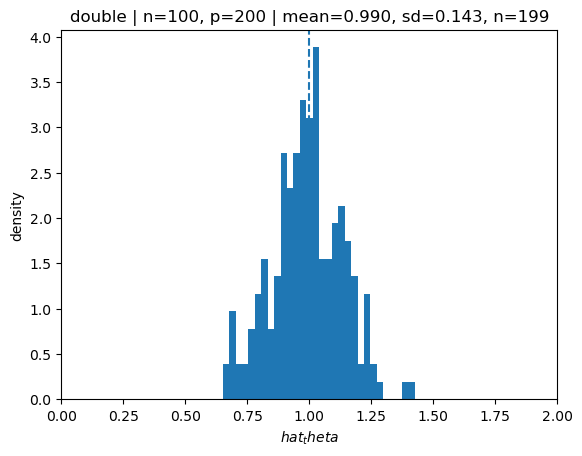

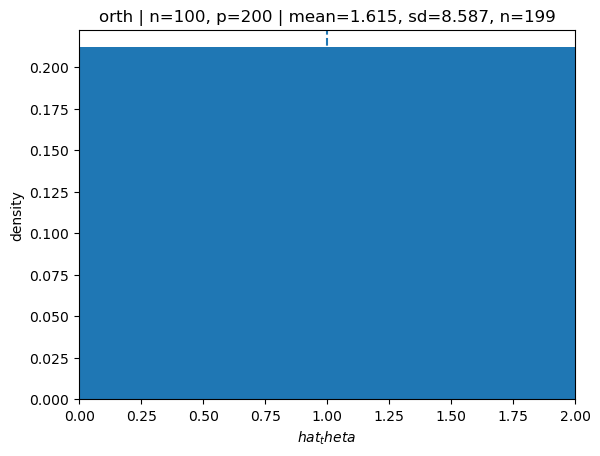

In [62]:
# --- PLOTTING (one figure per estimator × grid point) ---
def summarize(arr):
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return "all NaN"
    return f"mean={arr.mean():.3f}, sd={arr.std(ddof=1):.3f}, n={arr.size}"

for (n, p), ests in results.items():
    for name, arr in ests.items():
        clean = arr[~np.isnan(arr)]
        plt.figure()
        plt.hist(clean, bins=30, density=True)
        plt.axvline(theta_true, linestyle="--")
        plt.xlim(0, 2)
        plt.title(f"{name} | n={n}, p={p} | {summarize(clean)}")
        plt.xlabel(r"$hat_theta$")
        plt.ylabel("density")
        plt.show()

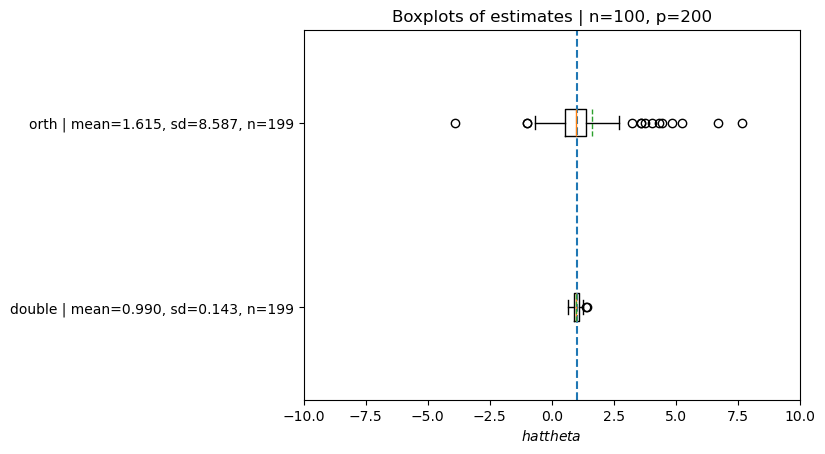

In [60]:
def summarize(arr):
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return "all NaN"
    return f"mean={arr.mean():.3f}, sd={arr.std(ddof=1):.3f}, n={arr.size}"

for (n, p), ests in results.items():
    data, labels = [], []
    for name, arr in ests.items():
        clean = arr[~np.isnan(arr)]
        if clean.size == 0:
            continue
        data.append(clean)
        labels.append(f"{name} | {summarize(clean)}")

    if not data:
        continue

    fig, ax = plt.subplots()
    ax.boxplot(data, vert=False, showmeans=True, meanline=True)  # boxplots instead of histograms
    ax.axvline(theta_true, linestyle="--")                       # reference line at truth
    ax.set_xlim(-10, 10)
    ax.set_title(f"Boxplots of estimates | n={n}, p={p}")
    ax.set_xlabel(r"$hat{theta}$")
    ax.set_yticklabels(labels)
    plt.show()


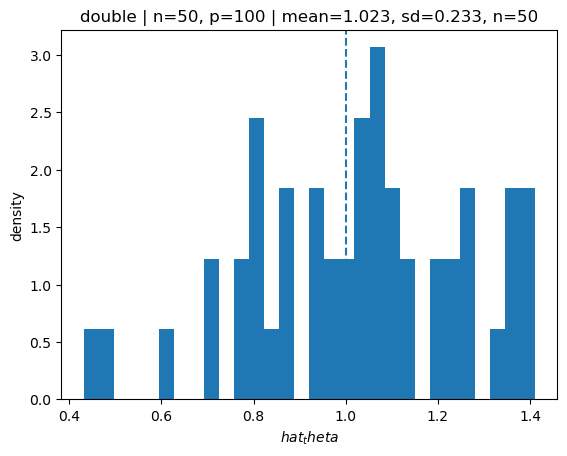

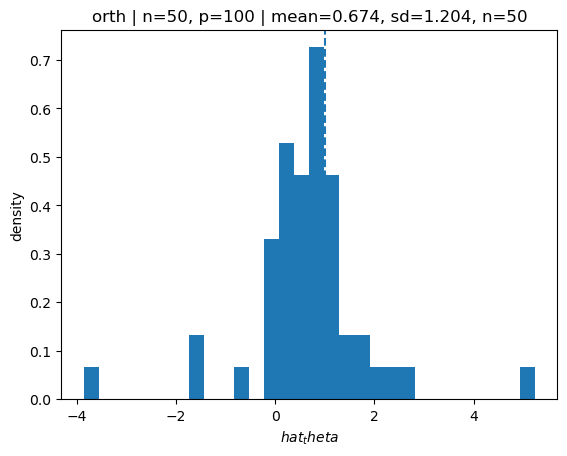

In [39]:
# --- PLOTTING (one figure per estimator × grid point) ---
def summarize(arr):
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return "all NaN"
    return f"mean={arr.mean():.3f}, sd={arr.std(ddof=1):.3f}, n={arr.size}"

for (n, p), ests in results.items():
    for name, arr in ests.items():
        clean = arr[~np.isnan(arr)]
        plt.figure()
        plt.hist(clean, bins=30, density=True)
        plt.axvline(theta_true, linestyle="--")   # truth
        plt.title(f"{name} | n={n}, p={p} | {summarize(clean)}")
        plt.xlabel(r"$hat_theta$")
        plt.ylabel("density")
        plt.show()

In [36]:
print(results)

{(50, 100): {'double': array([1.18951489, 0.80644204]), 'orth': array([0.60922151, 0.76560103])}}
